# Sequitur and graph metrics for speech

### metrics
- number of nodes
- number of edges
- predictability / entropy of adjacency matrix
- sequitur
- In general, a network is considered “complex” if it exhibits many features such as small diameter, high clustering coefficient, anticorrelation of node degrees, presence of network motifs, and modularity structures [8].
    - - https://www.hindawi.com/journals/complexity/2017/3250301/

In [133]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
from childes_mi.utils.paths import PHONBANK_DFS, DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import seaborn as sns

In [136]:
metrics_df = pd.read_pickle(DATA_DIR / 'sequitur_metrics.pickle')

In [137]:
metrics_df['mean_random_entropy'] = [np.mean(i) for i in metrics_df['random_entropy']]
metrics_df['mean_markov_entropy'] = [np.mean(i) for i in metrics_df['markov_entropy']]
metrics_df['mean_random_compression'] = [np.mean(i) for i in metrics_df['random_compression']]
metrics_df['mean_markov_compression'] = [np.mean(i) for i in metrics_df['markov_compression']]

In [138]:
metrics_df['transition_entropy_relative_to_random'] = metrics_df.mean_transition_entropy / metrics_df.mean_random_entropy

In [139]:
metrics_df['compression_relative_to_markov'] = metrics_df.sequitur_compression / metrics_df.mean_markov_compression

In [147]:
metrics_df['compression_relative_to_random'] = metrics_df.sequitur_compression / metrics_df.mean_random_compression

In [148]:
metrics_df["compression_relative_to_markov_bootstrapped_p"] =[ np.sum(row.markov_compression > row.sequitur_compression) / len(row.markov_compression) for idx, row in metrics_df.iterrows()]

In [149]:
age_cohort_dict = {
    0.5: "6-12",
    1: "12-18",
    1.5: "18-24",
    2: "24-30",
    2.5: "30-36",
    3: ">36",
}

In [150]:
metrics_df['age_cohort'] = [age_cohort_dict[row.age_cohort_low] for idx, row in metrics_df.iterrows()]

In [151]:
metrics_df[:3]

,n_unique_phones,n_phones,diameter,clustering_coefficient,sequitur_compression,mean_transition_entropy,age_cohort_low,age_cohort_high,markov_compression,random_compression,...,random_entropy,mean_random_entropy,mean_markov_entropy,mean_random_compression,mean_markov_compression,transition_entropy_relative_to_random,compression_relative_to_markov,compression_relative_to_markov_bootstrapped_p,age_cohort,compression_relative_to_random
0,41,2643,3.0,0.504382,0.368304,1.149222,0.5,1.0,"[0.3316582914572864, 0.3113207547169811, 0.297...","[0.2320675105485232, 0.23554603854389722, 0.23...",...,"[1.9521779247385465, 1.9599878923724965, 1.929...",1.936286,1.117788,0.233909,0.312860,0.593519,1.177214,0.000,6-12,1.574559
0,40,2280,3.0,0.495047,0.349112,1.509324,0.5,1.0,"[0.3333333333333333, 0.30412371134020616, 0.29...","[0.23543495610534718, 0.23867313915857605, 0.2...",...,"[2.1111646022748496, 2.0315112176307264, 1.956...",2.016989,1.386105,0.238995,0.311904,0.748305,1.119294,0.011,6-12,1.460751
0,28,627,5.0,0.400533,1.038339,0.829158,0.5,1.0,"[1.0220125786163523, 1.0655737704918034, 0.996...","[0.9129213483146067, 0.9475218658892128, 0.936...",...,"[1.1877991411513158, 1.280082640030571, 0.9685...",1.253338,0.761120,0.918611,1.024905,0.661559,1.013107,0.328,6-12,1.130335


In [152]:
np.sum(metrics_df["compression_relative_to_markov_bootstrapped_p"] > 0.05)

22

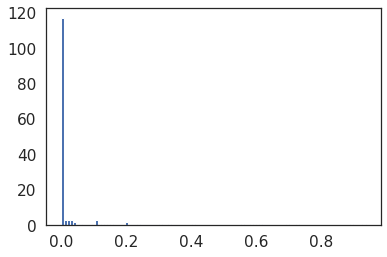

In [153]:
plt.hist(metrics_df["compression_relative_to_markov_bootstrapped_p"], bins= 100);

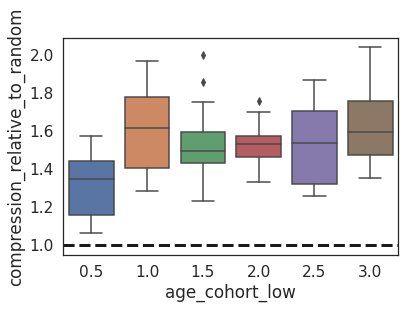

In [156]:
fig, ax = plt.subplots()
sns.boxplot(x = "age_cohort_low", y="compression_relative_to_random", data = metrics_df, ax=ax)
ax.axhline(1, lw=3, color='k', ls='dashed')
#ax.set_ylim([0, 1.2])

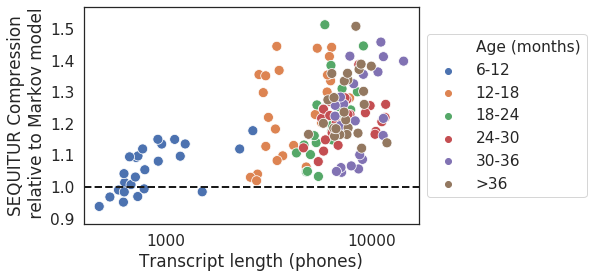

In [157]:
fig, ax = plt.subplots()
g = sns.scatterplot(x = "n_phones", y="compression_relative_to_markov", hue = "age_cohort", data = metrics_df, ax = ax, s = 100)
legend = g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.texts[0].set_text("Age (months)")
ax.axhline(1.0, lw=2, color = 'k', ls = 'dashed')
ax.set_xscale('log')
ax.set_ylabel('SEQUITUR Compression\n relative to Markov model')
ax.set_xlabel('Transcript length (phones)')
ax.set_xticks([1000, 10000])
ax.set_xticklabels([1000, 10000])
ensure_dir(FIGURE_DIR/ 'sequitur')
save_fig(FIGURE_DIR/ 'sequitur' / 'compression_relative_markov')

In [158]:
compression_comparison_df = metrics_df[["age_cohort", "mean_markov_compression", "sequitur_compression", "n_phones"]].melt(id_vars =['age_cohort', 'n_phones'])
compression_comparison_df[:3]

,age_cohort,n_phones,variable,value
0,6-12,2643,mean_markov_compression,0.312860
1,6-12,2280,mean_markov_compression,0.311904
2,6-12,627,mean_markov_compression,1.024905


In [159]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [160]:
mod = smf.ols(formula='value ~ variable + n_phones + age_cohort', data=compression_comparison_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     111.0
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           1.94e-78
Time:                        15:24:54   Log-Likelihood:                 266.78
No. Observations:                 300   AIC:                            -517.6
Df Residuals:                     292   BIC:                            -487.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

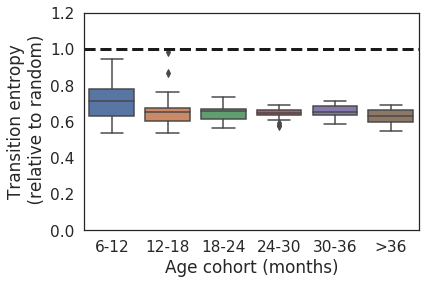

In [168]:
fig, ax = plt.subplots()
sns.boxplot(x = "age_cohort", y="transition_entropy_relative_to_random", data = metrics_df, ax=ax)
ax.axhline(1, lw=3, color='k', ls='dashed')
ax.set_ylabel('Transition entropy\n (relative to random)')
ax.set_xlabel('Age cohort (months)')
ax.set_ylim([0,1.2])
ensure_dir(FIGURE_DIR/ 'sequitur')
save_fig(FIGURE_DIR/ 'sequitur' / 'entropy_relative_random')

Text(0, 0.5, '# Unique phones in transcript')

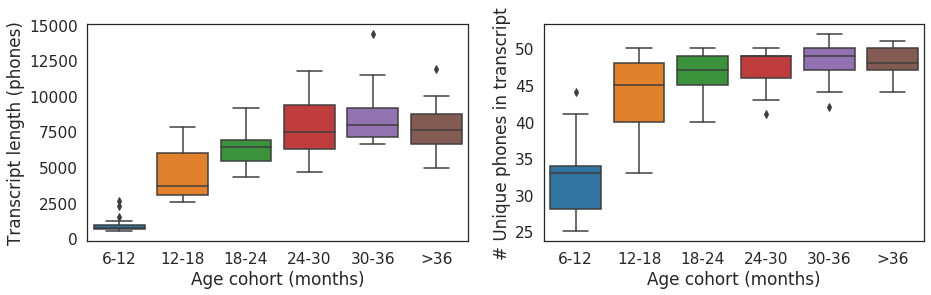

In [162]:
sns.set_context('paper')
sns.set(font_scale=1.4)
sns.set_style('white')
fig, axs = plt.subplots(ncols=2, figsize=(15,4))
ax = axs[0]
sns.boxplot(x = "age_cohort", y="n_phones", data = metrics_df, ax=ax, palette = "tab10")
ax.set_xlabel('Age cohort (months)')
ax.set_ylabel('Transcript length (phones)')

ax = axs[1]
sns.boxplot(x = "age_cohort", y="n_unique_phones", data = metrics_df, ax=axs[1], palette = "tab10")
ax.set_xlabel('Age cohort (months)')
ax.set_ylabel('# Unique phones in transcript')

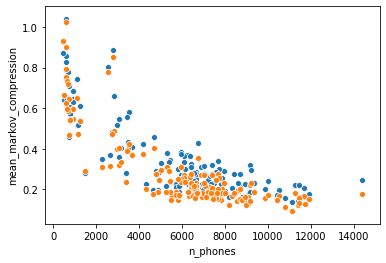

In [22]:
sns.scatterplot(x = "n_phones", y="sequitur_compression", data = metrics_df)
sns.scatterplot(x = "n_phones", y="mean_random_compression", data = metrics_df)

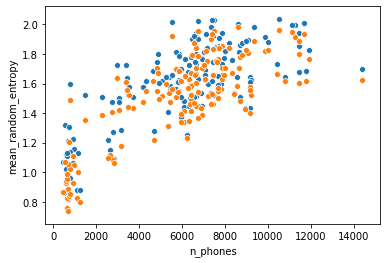

In [24]:
sns.scatterplot(x = "n_phones", y="mean_transition_entropy", data = metrics_df)
sns.scatterplot(x = "n_phones", y="mean_random_entropy", data = metrics_df, palette='dark')

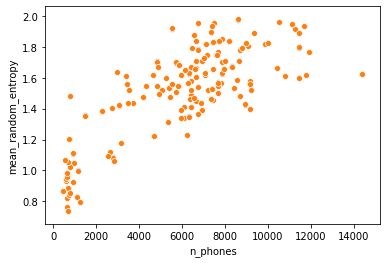

In [26]:
sns.scatterplot(x = "n_phones", y="mean_markov_entropy", data = metrics_df, palette='dark')
sns.scatterplot(x = "n_phones", y="mean_random_entropy", data = metrics_df, palette='dark')

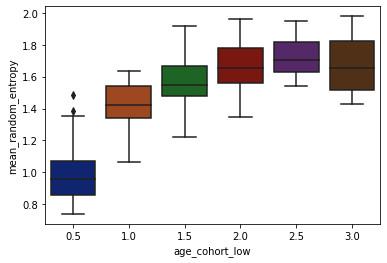

In [19]:
sns.boxplot(x = "age_cohort_low", y="mean_random_entropy", data = metrics_df, palette='dark')